In [1]:
from lifelines import CoxPHFitter, plotting
from lifelines.utils import k_fold_cross_validation, concordance_index
from lifelines.calibration import survival_probability_calibration
from lifelines.datasets import load_rossi
import numpy as np
import pandas as pd
from scipy import stats
from collections import Counter
from tableone import TableOne

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# This data set is originally from Rossi et al. (1980), and is used as an example in Allison (1995). 
# The data pertain to 432 convicts who were released from Maryland state prisons in the 1970s and who were 
# followed up for one year after release. Half the released convicts were assigned at random to an experimental 
# treatment in which they were given financial aid; half did not receive aid.
#
# The following variables are included in the data:
#
# week: week of first arrest after release, or censoring time.
# arrest: the event indicator, equal to 1 for those arrested during the period of the study and 0 for those who were not arrested.
# fin: a factor, equal to 1 if the individual received financial aid after release from prison, and 0 if he did not; financial aid was a randomly assigned factor manipulated by the researchers.
# age: in years at the time of release.
# race: a factor, equal to 1 if black and 0 if other.
# wexp: a factor, equal to 1 if the individual had full-time work experience prior to incarceration and equalt to 0 if he did not.
# mar: a factor, equal to 1 if the individual was married at the time of release and 0 if he was not.
# paro: a factor, equal to 1 if the individual was released on parole and 0 if he was not.
# prio: number of prior convictions.
#
# PS: The principal purpose of the recidivism study was to assess the impact of financial aid on rearrest.

rossi_df = load_rossi()

In [3]:
rossi_df.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


### Dataframe analysis

In [4]:
rossi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   week    432 non-null    int64
 1   arrest  432 non-null    int64
 2   fin     432 non-null    int64
 3   age     432 non-null    int64
 4   race    432 non-null    int64
 5   wexp    432 non-null    int64
 6   mar     432 non-null    int64
 7   paro    432 non-null    int64
 8   prio    432 non-null    int64
dtypes: int64(9)
memory usage: 30.5 KB


[]

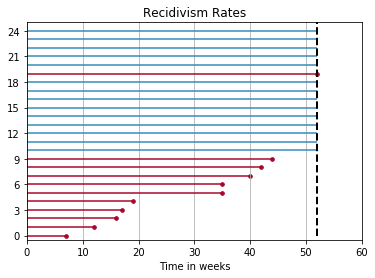

In [5]:
# Plotting only n individuals
df = rossi_df.sample(n=25, random_state=42)

durations = df.week.values
events = df.arrest.values

ax = plotting.plot_lifetimes(durations=durations, event_observed=events)
ax.set_xlim(0, 60)
ax.vlines(52, 0, 25, lw=2, linestyles='--')
ax.grid(axis='x')
ax.set_xlabel("Time in weeks")
ax.set_title("Recidivism Rates")
plt.plot()

In [6]:
# Table One
columns = ["arrest", "fin", "wexp", "mar", "paro"]
groupby = ['race']
nonnormal = ["age"]

# create an instance of TableOne with the input arguments
grouped_table = TableOne(rossi_df, columns=columns, groupby=groupby, nonnormal=nonnormal, missing=False)

# view tableone
grouped_table

Grouped by race            
                       0           1
n                     53         379
arrest 0       41 (77.4)  277 (73.1)
       1       12 (22.6)  102 (26.9)
fin    0       31 (58.5)  185 (48.8)
       1       22 (41.5)  194 (51.2)
wexp   0       20 (37.7)  165 (43.5)
       1       33 (62.3)  214 (56.5)
mar    0       44 (83.0)  335 (88.4)
       1        9 (17.0)   44 (11.6)
paro   0       23 (43.4)  142 (37.5)
       1       30 (56.6)  237 (62.5)

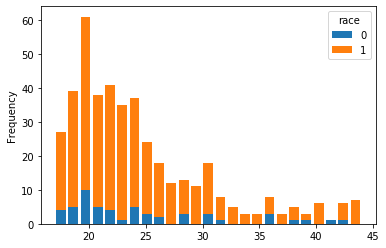

In [7]:
# age distribution
rossi_df.pivot(columns='race').age.plot(kind = 'hist', stacked=True, bins=25, rwidth=0.8)

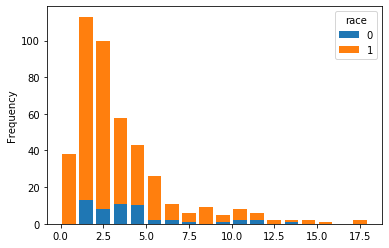

In [8]:
# prior arrest distribution
rossi_df.pivot(columns='race').prio.plot(kind = 'hist', stacked=True, bins=18, rwidth=0.8)

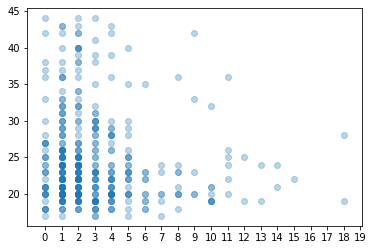

In [9]:
# Prior arrests by age
x = rossi_df["prio"]
y = rossi_df["age"]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, 20, 1)
ax.set_xticks(major_ticks)
plt.scatter(x, y, alpha=0.3)

### Model

In [10]:
rossi_df['age_strata'] = pd.cut(rossi_df['age'], np.arange(0, 80, 5))
rossi_df = rossi_df.drop('age', axis=1)

cph = CoxPHFitter()
cph.fit(rossi_df, duration_col='week', event_col='arrest', strata=['age_strata', 'wexp'])

/Users/bruna/miniconda3/envs/fairness-health/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>

In [11]:
cph.check_assumptions(rossi_df)

Proportional hazard assumption looks okay.


[]

In [12]:
# scores = k_fold_cross_validation(cph, rossi_df, duration_col='week', event_col='arrest', k=10, scoring_method="concordance_index")
# print(np.mean(scores))

In [13]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
                   strata = ['age_strata', 'wexp']
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -434.50
         time fit was run = 2020-12-23 12:58:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
fin        -0.41       0.67       0.19            -0.79            -0.03                 0.46                 0.97
race        0.29       1.33       0.31            -0.32             0.90                 0.73                 2.45
mar        -0.34       0.71       0.39            -1.10             0.42                 0.33                 1.52
paro       -0.10       0.91       0.20            -0.48             0.29                 0.62                 1.33
prio        0.08       1.08       0.03             0.02             0.14                 1.03                 1.15

              z      p   -log2(p)
covariate                        
fin       -2.10   0.04       4.82
race       0.93   0.35       1.50
mar       -0.87   0.38       1.38
paro      -0.50   0.62       0.70
prio       2.83 <0.005       7.73
---
Concordance = 0.57
Partial AIC = 879.01
log-likelihood ratio test = 13.12 on 5 df
-log2(p) of ll-ratio test = 5.49

### Covariates

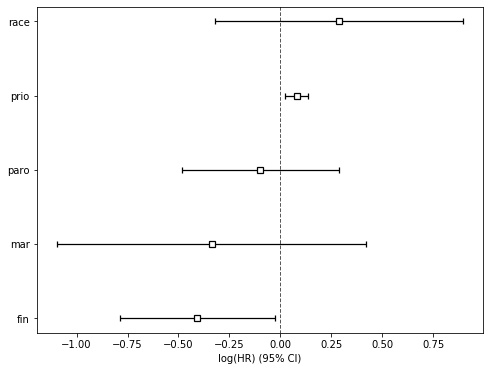

In [14]:
ax = plt.subplots(figsize=(8, 6))
cph.plot(ax=ax[1])

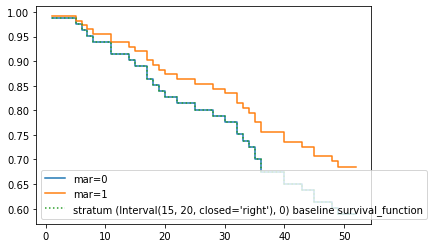

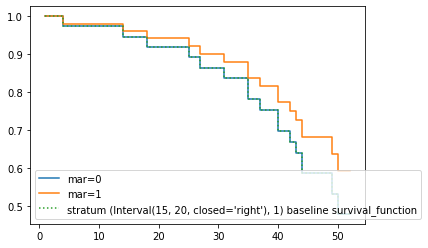

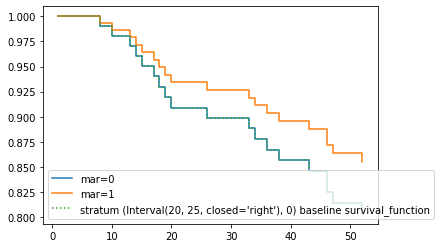

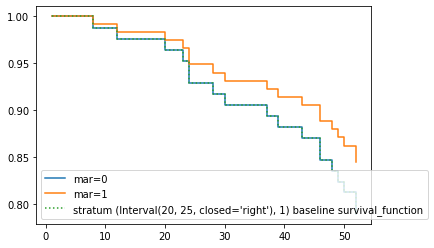

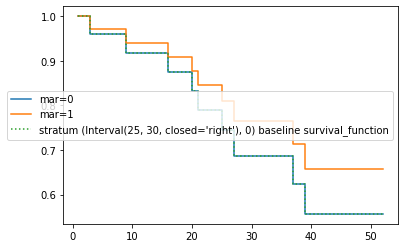

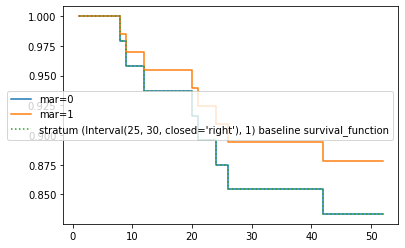

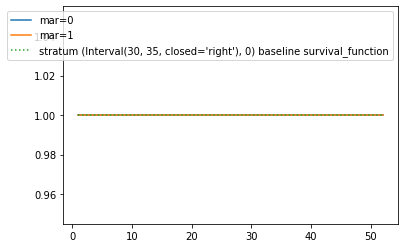

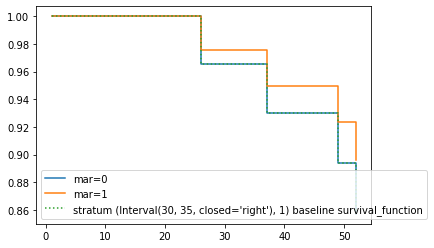

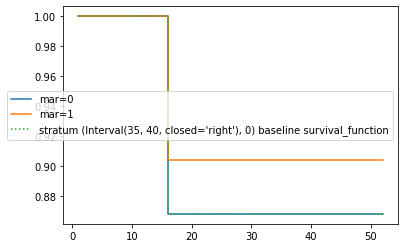

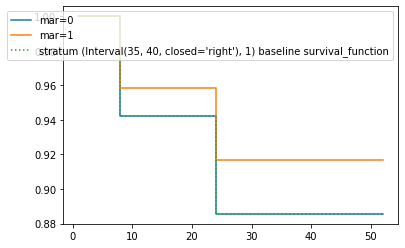

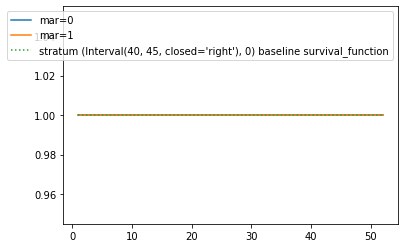

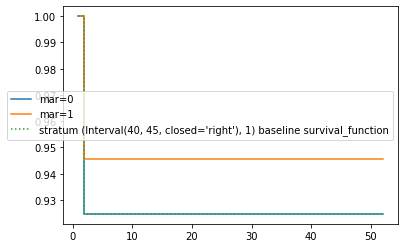

In [15]:
cph.plot_partial_effects_on_outcome('mar', values=np.arange(0, 2, 1))

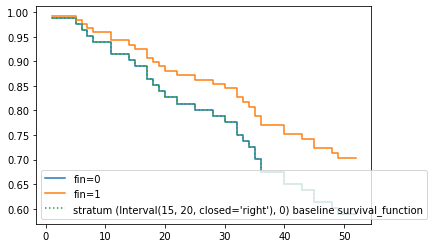

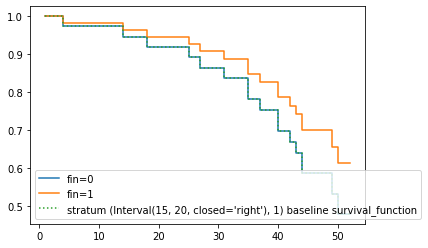

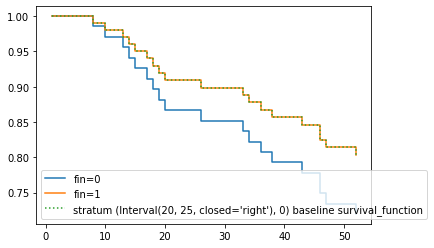

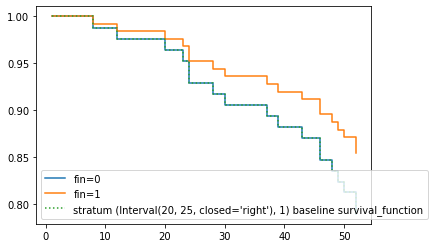

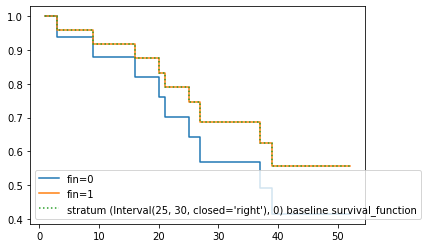

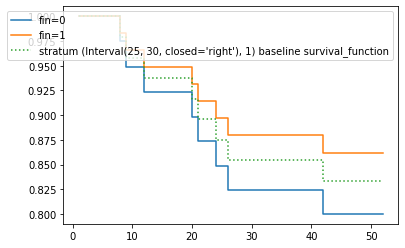

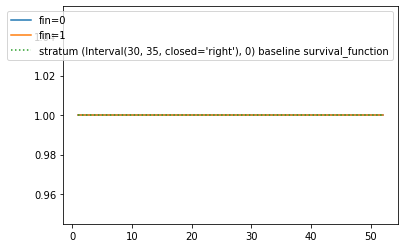

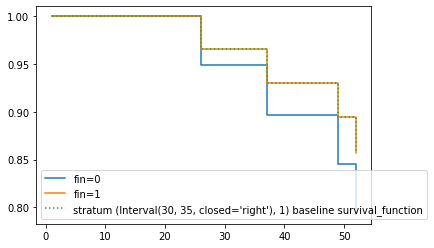

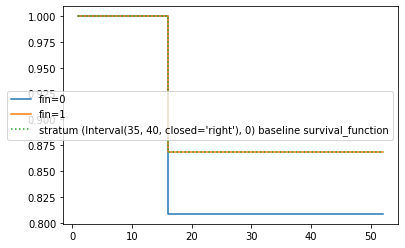

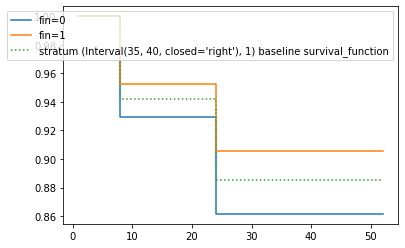

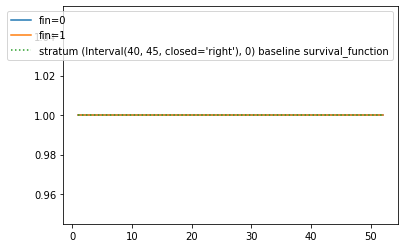

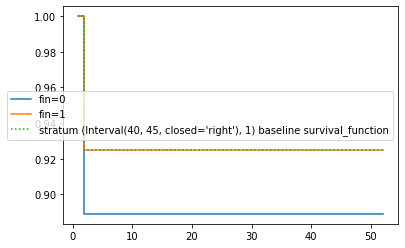

In [16]:
cph.plot_partial_effects_on_outcome('fin', values=np.arange(0, 2, 1))

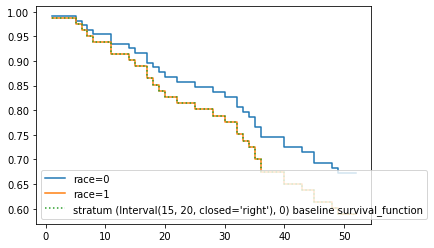

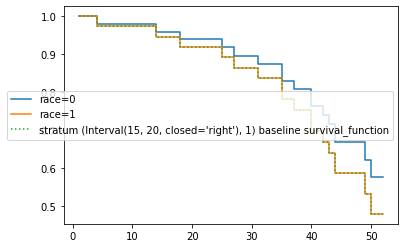

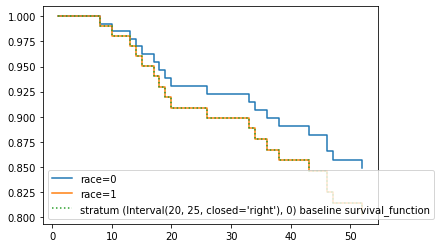

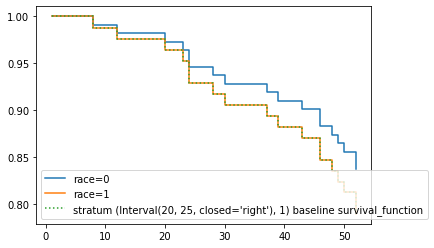

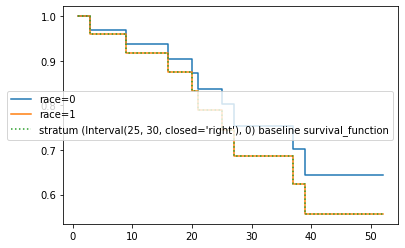

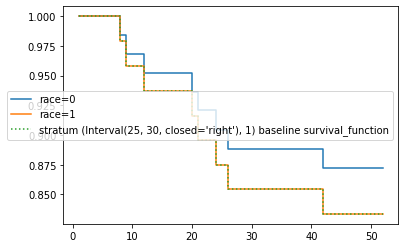

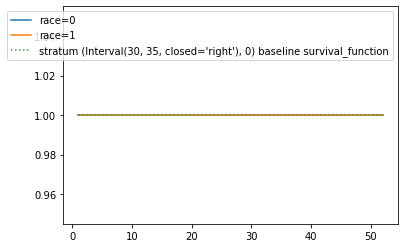

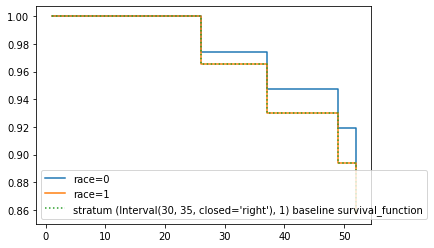

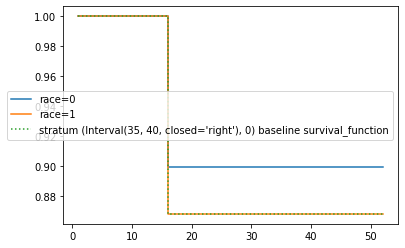

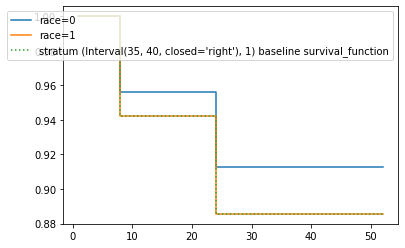

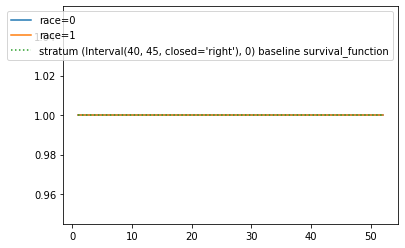

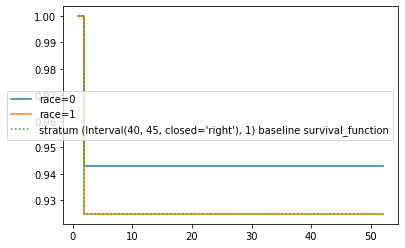

In [17]:
cph.plot_partial_effects_on_outcome('race', values=np.arange(0, 2, 1))

### Fairness

In [18]:
def survival_curve_plot(surv1, surv2, label1, label2):

    df_surv_median1, df_surv_std1, df_surv_median2, df_surv_std2 = survival_curve_median_calc(surv1, surv2)

    # Compute stats: tests whether 2 samples are drawn from the same distribution
    # H0: samples are drawn from the same distribution
    # H1: samples are not drawn from the same distribution
    
    # If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis 
    # that the distributions of the two samples are the same.
    test = compute_stats(df_surv_median1, df_surv_median2)

    # Plot curves 
    ax = plt.subplots(figsize=(8, 6))
    
    # 95% Confidence interval
    ci1_left = surv1.quantile(0.025, axis=1)
    ci1_right = surv1.quantile(0.975, axis=1)
    ci2_left = surv2.quantile(0.025, axis=1)
    ci2_right = surv2.quantile(0.975, axis=1)
    
    ax = df_surv_median1.plot(label=label1, color='turquoise', linestyle='--')
    ax.fill_between(df_surv_median1.index, ci1_left, ci1_right, alpha=0.2, facecolor='turquoise')

    ax.plot(df_surv_median2, label=label2, color='slateblue', linestyle='-.')
    ax.fill_between(df_surv_median2.index, ci2_left, ci2_right, alpha=0.2, facecolor='slateblue')

    plt.text(0.2, 0.2, str(test), fontsize=8, transform=plt.gcf().transFigure)
    plt.legend(loc="upper right")
    plt.ylabel('S(t | x)')
    plt.xlabel('Time')

In [19]:
def survival_curve_median_calc(surv1, surv2):
    # Median and standard deviation
    df_surv_median1 = surv1.median(axis=1)
    df_surv_std1 = surv1.std(axis=1)
    df_surv_median2 = surv2.median(axis=1)
    df_surv_std2 = surv2.std(axis=1)

    return df_surv_median1, df_surv_std1, df_surv_median2, df_surv_std2

In [20]:
def compute_stats(rvs1, rvs2):
    test_stat = stats.ks_2samp(rvs1, rvs2)
    return test_stat

#### Group Fairness

Survival rates (S(t)) simply gives us the probability that event will not occur beyond time t, in this case, rearrest.

In [21]:
df_black = rossi_df.loc[rossi_df["race"] == 1]
df_other = rossi_df.loc[rossi_df["race"] == 0]
label1= "black"
label2= "other"

df_fin = rossi_df.loc[rossi_df["fin"] == 1]
df_not_fin = rossi_df.loc[rossi_df["fin"] == 0]
label3= "fin"
label4= "not fin"

df_mar = rossi_df.loc[rossi_df["mar"] == 1]
df_not_mar = rossi_df.loc[rossi_df["mar"] == 0]
label5= "married"
label6= "not married"

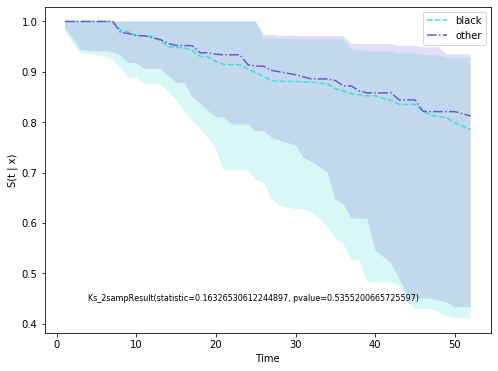

In [22]:
# Race
surv_black = cph.predict_survival_function(df_black)
surv_other = cph.predict_survival_function(df_other)
survival_curve_plot(surv_black, surv_other, label1, label2)

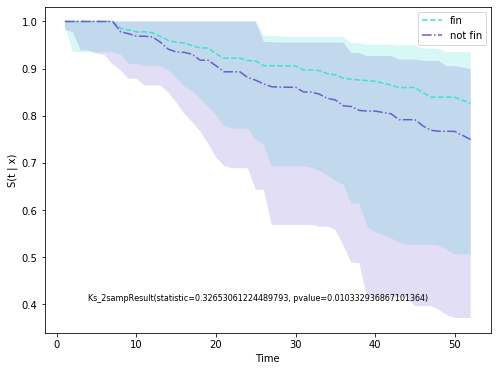

In [23]:
# Received financial aid **
surv_fin = cph.predict_survival_function(df_fin)
surv_not_fin = cph.predict_survival_function(df_not_fin)
survival_curve_plot(surv_fin, surv_not_fin, label3, label4)

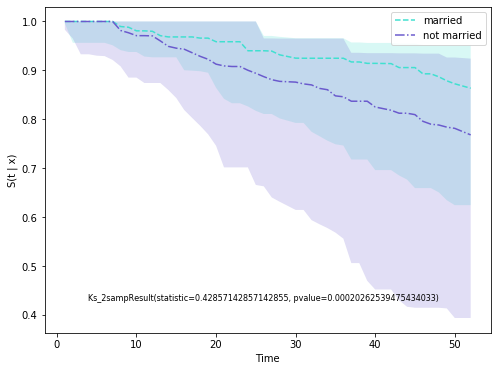

In [24]:
# Married ***
surv_mar = cph.predict_survival_function(df_mar)
surv_not_mar = cph.predict_survival_function(df_not_mar)
survival_curve_plot(surv_mar, surv_not_mar, label5, label6)

#### Conditional statistical parity

In [25]:
df1 = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 1)]
df2 = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 0)]
label1= "black, married, financial aid"
label2= "black, married, not financial aid"

df3 = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 1)]
df4 = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 0)]
label3= "black, not married, financial aid"
label4= "black, not married, not financial aid"

df5 = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 1)]
df6 = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 0)]
label5= "other, married, financial aid"
label6= "other, married, not financial aid"

df7 = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 1)]
df8 = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 0)]
label7= "other, not married, financial aid"
label8= "other, not married, not financial aid"

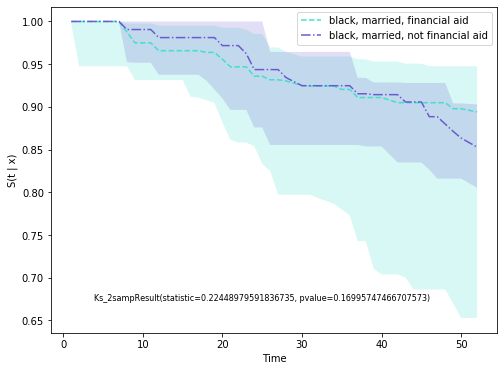

In [26]:
# Black, married, received or not financial aid
surv1 = cph.predict_survival_function(df1)
surv2 = cph.predict_survival_function(df2)
survival_curve_plot(surv1, surv2, label1, label2)

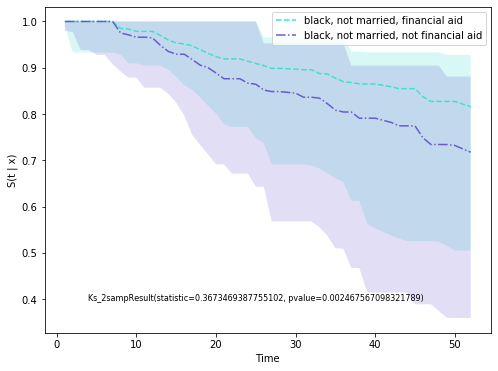

In [27]:
# Black, not married, received or not financial aid **
surv3 = cph.predict_survival_function(df3)
surv4 = cph.predict_survival_function(df4)
survival_curve_plot(surv3, surv4, label3, label4)

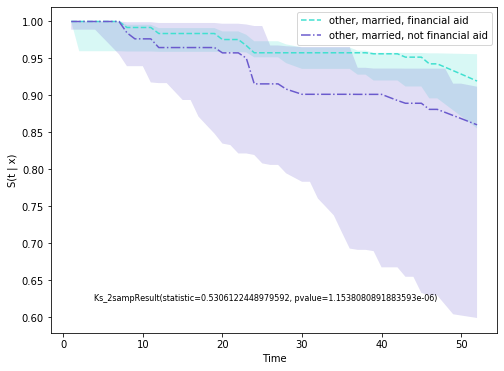

In [28]:
# Other, married, received or not financial aid ****
surv5 = cph.predict_survival_function(df5)
surv6 = cph.predict_survival_function(df6)
survival_curve_plot(surv5, surv6, label5, label6)

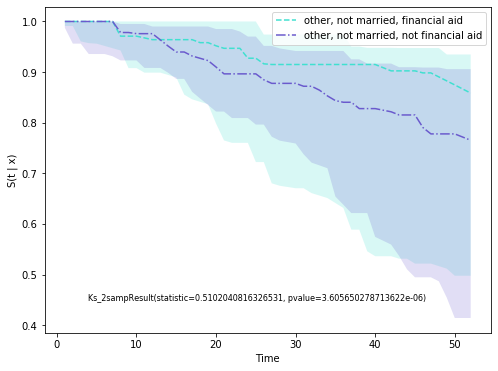

In [29]:
# Other, not married, received or not financial aid ****
surv7 = cph.predict_survival_function(df7)
surv8 = cph.predict_survival_function(df8)
survival_curve_plot(surv7, surv8, label7, label8)

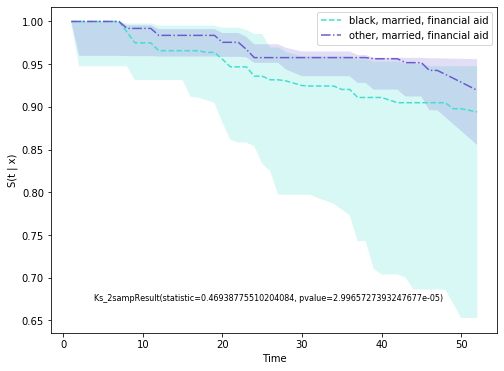

In [30]:
# race, married, received financial aid *****
surv1 = cph.predict_survival_function(df1)
surv5 = cph.predict_survival_function(df5)
survival_curve_plot(surv1, surv5, label1, label5)

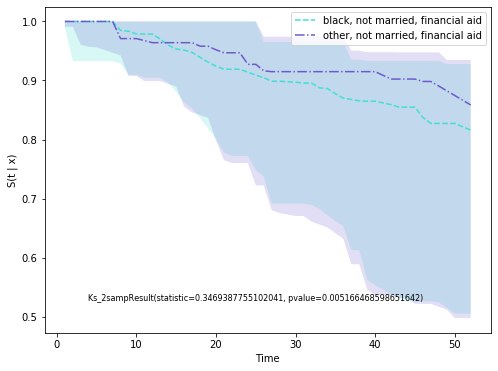

In [31]:
# race, not married, received financial aid ***
surv3 = cph.predict_survival_function(df3)
surv7 = cph.predict_survival_function(df7)
survival_curve_plot(surv3, surv7, label3, label7)

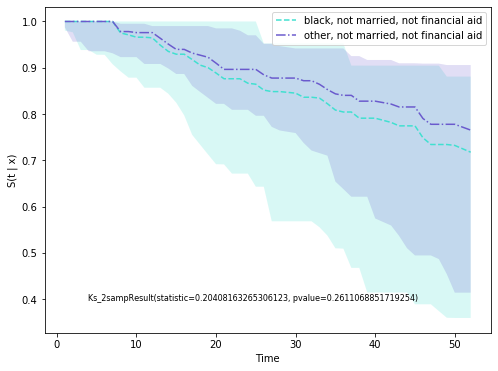

In [32]:
# race, not married, did not receive financial aid 
surv4 = cph.predict_survival_function(df4)
surv8 = cph.predict_survival_function(df8)
survival_curve_plot(surv4, surv8, label4, label8)

#### Modified C-Index

In [33]:
from pycox.evaluation import EvalSurv

In [52]:
print(cph.concordance_index_)

0.5699826031946861


In [48]:
# pycox time dependent c-index
surv = cph.predict_survival_function(rossi_df)
ev = EvalSurv(surv, rossi_df["week"].to_numpy(), rossi_df["arrest"].to_numpy())
cindex = ev.concordance_td()
print(cindex)

0.4760073509392867


In [36]:
def evaluate_modified_cindex(durations_g1, durations_g2, events_g1, events_g2, surv_g1, surv_g2):
    ev_g1 = EvalSurv(surv_g1, durations_g1, events_g1)
    ev_g2 = EvalSurv(surv_g2, durations_g2, events_g2)

    # c-index
    cindex_g1 = ev_g1.concordance_td()
    cindex_g2 = ev_g2.concordance_td()

    # modified c-index
    cindex_modified_g1 = ev_g1.concordance_td_modified_for_groups(durations_g2, events_g2, surv_g2)
    cindex_modified_g2 = ev_g2.concordance_td_modified_for_groups(durations_g1, events_g1, surv_g1)

    cindex_modified_g1_time_event = ev_g1.concordance_td_modified_for_groups_time_event(durations_g2, events_g2, surv_g2)
    cindex_modified_g2_time_event = ev_g2.concordance_td_modified_for_groups_time_event(durations_g1, events_g1, surv_g1)

    return cindex_g1, cindex_g2, cindex_modified_g1, cindex_modified_g2, cindex_modified_g1_time_event, cindex_modified_g2_time_event


In [37]:
# Race
cindex_black, cindex_other, cindex_modified_black_other, cindex_modified_other_black, cindex_modified_black_other_time_event, cindex_modified_other_black_time_event = evaluate_modified_cindex(df_black["week"].to_numpy(), df_other["week"].to_numpy(), df_black["arrest"].to_numpy(), df_other["arrest"].to_numpy(), surv_black, surv_other)

print(cindex_black, cindex_other) 
print(cindex_modified_black_other[0]/cindex_modified_black_other[1], cindex_modified_black_other)
print(cindex_modified_other_black[0]/cindex_modified_other_black[1], cindex_modified_other_black)
print(cindex_modified_black_other_time_event[0]/cindex_modified_black_other_time_event[1], cindex_modified_black_other_time_event)
print(cindex_modified_other_black_time_event[0]/cindex_modified_other_black_time_event[1], cindex_modified_other_black_time_event)


0.48343772760378734 0.38870431893687707
0.2820978219335116 (1476.5, 5234.0)
0.1360153256704981 (532.5, 3915.0)
0.7179021780664884 (3757.5, 5234.0)
0.8639846743295019 (3382.5, 3915.0)


In [38]:
# Financial Aid
cindex_fin, cindex_not_fin, cindex_modified_fin, cindex_modified_not_fin, cindex_modified_fin_not_fin_time_event, cindex_modified_not_fin_fin_time_event = evaluate_modified_cindex(df_fin["week"].to_numpy(), df_not_fin["week"].to_numpy(), df_fin["arrest"].to_numpy(), df_not_fin["arrest"].to_numpy(), surv_fin, surv_not_fin)

print(cindex_fin, cindex_not_fin) 
print(cindex_modified_fin[0]/cindex_modified_fin[1], cindex_modified_fin)
print(cindex_modified_not_fin[0]/cindex_modified_not_fin[1], cindex_modified_not_fin)
print(cindex_modified_fin_not_fin_time_event[0]/cindex_modified_fin_not_fin_time_event[1], cindex_modified_fin_not_fin_time_event)
print(cindex_modified_not_fin_fin_time_event[0]/cindex_modified_not_fin_fin_time_event[1], cindex_modified_not_fin_fin_time_event)


0.4167118533781585 0.47243690851735015
0.11070071760236387 (1049.0, 9476.0)
0.31884400346483976 (4049.0, 12699.0)
0.8892992823976361 (8427.0, 9476.0)
0.6811559965351602 (8650.0, 12699.0)


In [39]:
# Married
cindex_mar, cindex_not_mar, cindex_modified_mar, cindex_modified_not_mar, cindex_modified_mar_not_mar_time_event, cindex_modified_not_mar_mar_time_event = evaluate_modified_cindex(df_mar["week"].to_numpy(), df_not_mar["week"].to_numpy(), df_mar["arrest"].to_numpy(), df_not_mar["arrest"].to_numpy(), surv_mar, surv_not_mar)

print(cindex_fin, cindex_not_fin) 
print(cindex_modified_fin[0]/cindex_modified_fin[1], cindex_modified_fin)
print(cindex_modified_not_fin[0]/cindex_modified_not_fin[1], cindex_modified_not_fin)
print(cindex_modified_fin_not_fin_time_event[0]/cindex_modified_fin_not_fin_time_event[1], cindex_modified_fin_not_fin_time_event)
print(cindex_modified_not_fin_fin_time_event[0]/cindex_modified_not_fin_fin_time_event[1], cindex_modified_not_fin_fin_time_event)


0.4167118533781585 0.47243690851735015
0.11070071760236387 (1049.0, 9476.0)
0.31884400346483976 (4049.0, 12699.0)
0.8892992823976361 (8427.0, 9476.0)
0.6811559965351602 (8650.0, 12699.0)


In [40]:
# Race and financial aid
df_black_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["fin"] == 1)]
df_other_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["fin"] == 1)]

surv_black_fin = cph.predict_survival_function(df_black_fin)
surv_other_fin = cph.predict_survival_function(df_other_fin)

cindex_black_fin, cindex_other_fin, cindex_modified_black_fin, cindex_modified_other_fin, cindex_modified_black_fin_time_event, cindex_modified_other_fin_time_event = evaluate_modified_cindex(df_black_fin["week"].to_numpy(), df_other_fin["week"].to_numpy(), df_black_fin["arrest"].to_numpy(), df_other_fin["arrest"].to_numpy(), surv_black_fin, surv_other_fin)

print(cindex_black_fin, cindex_other_fin) 
print(cindex_modified_black_fin[0]/cindex_modified_black_fin[1], cindex_modified_black_fin)
print(cindex_modified_other_fin[0]/cindex_modified_other_fin[1], cindex_modified_other_fin)
print(cindex_modified_black_fin_time_event[0]/cindex_modified_black_fin_time_event[1], cindex_modified_black_fin_time_event)
print(cindex_modified_other_fin_time_event[0]/cindex_modified_other_fin_time_event[1], cindex_modified_other_fin_time_event)


0.4221473851030111 0.48717948717948717
0.2739032620922385 (243.5, 889.0)
0.2470674486803519 (168.5, 682.0)
0.7260967379077615 (645.5, 889.0)
0.7529325513196481 (513.5, 682.0)


In [41]:
# Race and no financial aid
df_black_not_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["fin"] == 0)]
df_other_not_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["fin"] == 0)]

surv_black_not_fin = cph.predict_survival_function(df_black_not_fin)
surv_other_not_fin = cph.predict_survival_function(df_other_not_fin)

cindex_black_not_fin, cindex_other_not_fin, cindex_modified_black_not_fin, cindex_modified_other_not_fin, cindex_modified_black_not_fin_time_event, cindex_modified_other_not_fin_time_event = evaluate_modified_cindex(df_black_not_fin["week"].to_numpy(), df_other_not_fin["week"].to_numpy(), df_black_not_fin["arrest"].to_numpy(), df_other_not_fin["arrest"].to_numpy(), surv_black_not_fin, surv_other_not_fin)

print(cindex_black_not_fin, cindex_other_not_fin) 
print(cindex_modified_black_not_fin[0]/cindex_modified_black_not_fin[1], cindex_modified_black_not_fin)
print(cindex_modified_other_not_fin[0]/cindex_modified_other_not_fin[1], cindex_modified_other_not_fin)
print(cindex_modified_black_not_fin_time_event[0]/cindex_modified_black_not_fin_time_event[1], cindex_modified_black_not_fin_time_event)
print(cindex_modified_other_not_fin_time_event[0]/cindex_modified_other_not_fin_time_event[1], cindex_modified_other_not_fin_time_event)


0.4802589683718956 0.47478991596638653
0.27416619559072924 (485.0, 1769.0)
0.16866506794564348 (211.0, 1251.0)
0.7258338044092708 (1284.0, 1769.0)
0.8313349320543565 (1040.0, 1251.0)


In [42]:
# More stratified: race, married and financial aid ------> zero pairs!
# df_black_married_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 1)]
# df_other_married_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 1)]

# surv_black_married_fin = cph.predict_survival_function(df_black_married_fin)
# surv_other_married_fin = cph.predict_survival_function(df_other_married_fin)

# cindex_black_married_fin, cindex_other_married_fin, cindex_modified_black_married_fin, cindex_modified_other_married_fin, cindex_modified_black_married_fin_time_event, cindex_modified_other_married_fin_time_event = evaluate_modified_cindex(df_black_married_fin["week"].to_numpy(), df_other_married_fin["week"].to_numpy(), df_black_married_fin["arrest"].to_numpy(), df_other_married_fin["arrest"].to_numpy(), surv_black_married_fin, surv_other_married_fin)

# print(cindex_black_married_fin, cindex_other_married_fin) 
# print(cindex_modified_black_married_fin[0]/cindex_modified_black_married_fin[1], cindex_modified_black_married_fin)
# print(cindex_modified_other_married_fin[0]/cindex_modified_other_married_fin[1], cindex_modified_other_married_fin)
# print(cindex_modified_black_married_fin_time_event[0]/cindex_modified_black_married_fin_time_event[1], cindex_modified_black_married_fin_time_event)
# print(cindex_modified_other_married_fin_time_event[0]/cindex_modified_other_married_fin_time_event[1], cindex_modified_other_married_fin_time_event)


In [43]:
# race, married and no financial aid
df_black_married_not_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 0)]
df_other_married_not_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 1) & (rossi_df["fin"] == 0)]

surv_black_married_not_fin = cph.predict_survival_function(df_black_married_not_fin)
surv_other_married_not_fin = cph.predict_survival_function(df_other_married_not_fin)

cindex_black_married_not_fin, cindex_other_married_not_fin, cindex_modified_black_married_not_fin, cindex_modified_other_married_not_fin, cindex_modified_black_married_not_fin_time_event, cindex_modified_other_married_not_fin_time_event = evaluate_modified_cindex(df_black_married_not_fin["week"].to_numpy(), df_other_married_not_fin["week"].to_numpy(), df_black_married_not_fin["arrest"].to_numpy(), df_other_married_not_fin["arrest"].to_numpy(), surv_black_married_not_fin, surv_other_married_not_fin)

print(cindex_black_married_not_fin, cindex_other_married_not_fin) 
print(cindex_modified_black_married_not_fin[0]/cindex_modified_black_married_not_fin[1], cindex_modified_black_married_not_fin)
print(cindex_modified_other_married_not_fin[0]/cindex_modified_other_married_not_fin[1], cindex_modified_other_married_not_fin)
print(cindex_modified_black_married_not_fin_time_event[0]/cindex_modified_black_married_not_fin_time_event[1], cindex_modified_black_married_not_fin_time_event)
print(cindex_modified_other_married_not_fin_time_event[0]/cindex_modified_other_married_not_fin_time_event[1], cindex_modified_other_married_not_fin_time_event)


0.3231707317073171 0.2
0.06521739130434782 (1.5, 23.0)
0.023809523809523808 (0.5, 21.0)
0.9347826086956522 (21.5, 23.0)
0.9761904761904762 (20.5, 21.0)


In [44]:
# race, not married and financial aid
df_black_not_married_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 1)]
df_other_not_married_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 1)]

surv_black_not_married_fin = cph.predict_survival_function(df_black_not_married_fin)
surv_other_not_married_fin = cph.predict_survival_function(df_other_not_married_fin)

cindex_black_not_married_fin, cindex_other_not_married_fin, cindex_modified_black_not_married_fin, cindex_modified_other_not_married_fin, cindex_modified_black_not_married_fin_time_event, cindex_modified_other_not_married_fin_time_event = evaluate_modified_cindex(df_black_not_married_fin["week"].to_numpy(), df_other_not_married_fin["week"].to_numpy(), df_black_not_married_fin["arrest"].to_numpy(), df_other_not_married_fin["arrest"].to_numpy(), surv_black_not_married_fin, surv_other_not_married_fin)

print(cindex_black_not_married_fin, cindex_other_not_married_fin) 
print(cindex_modified_black_not_married_fin[0]/cindex_modified_black_not_married_fin[1], cindex_modified_black_not_married_fin)
print(cindex_modified_other_not_married_fin[0]/cindex_modified_other_not_married_fin[1], cindex_modified_other_not_married_fin)
print(cindex_modified_black_not_married_fin_time_event[0]/cindex_modified_black_not_married_fin_time_event[1], cindex_modified_black_not_married_fin_time_event)
print(cindex_modified_other_not_married_fin_time_event[0]/cindex_modified_other_not_married_fin_time_event[1], cindex_modified_other_not_married_fin_time_event)


0.39258312020460356 0.5378787878787878
0.22418670438472418 (158.5, 707.0)
0.26285240464344944 (158.5, 603.0)
0.7758132956152758 (548.5, 707.0)
0.7371475953565506 (444.5, 603.0)


In [45]:
# race, not married and no financial aid
df_black_not_married_not_fin = rossi_df.loc[(rossi_df["race"] == 1) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 0)]
df_other_not_married_not_fin = rossi_df.loc[(rossi_df["race"] == 0) & (rossi_df["mar"] == 0) & (rossi_df["fin"] == 0)]

surv_black_not_married_not_fin = cph.predict_survival_function(df_black_not_married_not_fin)
surv_other_not_married_not_fin = cph.predict_survival_function(df_other_not_married_not_fin)

cindex_black_not_married_not_fin, cindex_other_not_married_not_fin, cindex_modified_black_not_married_not_fin, cindex_modified_other_not_married_not_fin, cindex_modified_black_not_married_not_fin_time_event, cindex_modified_other_not_married_not_fin_time_event = evaluate_modified_cindex(df_black_not_married_not_fin["week"].to_numpy(), df_other_not_married_not_fin["week"].to_numpy(), df_black_not_married_not_fin["arrest"].to_numpy(), df_other_not_married_not_fin["arrest"].to_numpy(), surv_black_not_married_not_fin, surv_other_not_married_not_fin)

print(cindex_black_not_married_not_fin, cindex_other_not_married_not_fin) 
print(cindex_modified_black_not_married_not_fin[0]/cindex_modified_black_not_married_not_fin[1], cindex_modified_black_not_married_not_fin)
print(cindex_modified_other_not_married_not_fin[0]/cindex_modified_other_not_married_not_fin[1], cindex_modified_other_not_married_not_fin)
print(cindex_modified_black_not_married_not_fin_time_event[0]/cindex_modified_black_not_married_not_fin_time_event[1], cindex_modified_black_not_married_not_fin_time_event)
print(cindex_modified_other_not_married_not_fin_time_event[0]/cindex_modified_other_not_married_not_fin_time_event[1], cindex_modified_other_not_married_not_fin_time_event)


0.4659524122518733 0.3885542168674699
0.2513187641296157 (333.5, 1327.0)
0.14820675105485231 (140.5, 948.0)
0.7486812358703844 (993.5, 1327.0)
0.8517932489451476 (807.5, 948.0)
